In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf

# Load the saved MobileNet model
model = tf.keras.models.load_model("/content/drive/MyDrive/weapon_detection_model_mobilenet.h5")

# Freeze all layers to prevent them from being trained
for layer in model.layers:
    layer.trainable = False

# Create a new model without the last layer
output = model.layers[-2].output  # Get the output of the second-to-last layer
model = tf.keras.Model(inputs=model.inputs, outputs=output)

# Display model summary to ensure it's loaded correctly
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [6]:
!git clone https://github.com/ari-dasci/OD-WeaponDetection.git

Cloning into 'OD-WeaponDetection'...
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10232/10232), done.
remote: Total 50755 (delta 11), reused 11673 (delta 11), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 32.30 MiB/s, done.
Resolving deltas: 100% (10978/10978), done.
Updating files: 100% (63128/63128), done.


In [7]:
%cd /content
%mkdir dataset
%cd dataset
%mkdir knife
%mkdir guns
%cp -r "/content/OD-WeaponDetection/Knife_detection/Images/." knife
%cp -r "/content/OD-WeaponDetection/Pistol detection/Weapons/." guns
%cp -r "/content/OD-WeaponDetection/Weapons and similar handled objects/Sohas_weapon-Detection/images/." handheld

/content
/content/dataset


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the directory containing your dataset
dataset_dir = '/content/dataset'

# Get the list of subdirectories (classes) in the dataset directory
classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name)) and class_name != ".git"]

# Define the dimensions for resizing the images
img_height, img_width = 224, 224

# Define batch size for training and validation
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=classes
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=classes
)

# Print the number of classes and their labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

class_labels = train_generator.class_indices
print("Class labels:", class_labels)

Found 8569 images belonging to 3 classes.
Found 1511 images belonging to 3 classes.
Number of classes: 3
Class labels: {'guns': 0, 'knife': 1, 'handheld': 2}


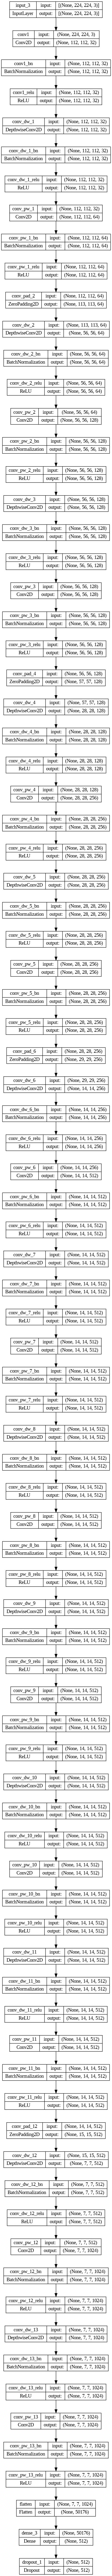

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='mobilenet_feature_extractor.png', show_shapes=True, show_layer_names=True)

In [10]:
# Extract features using the pre-trained model
features = model.predict(train_generator, verbose=1)

# Reshape features to have one feature vector per image
features = features.reshape((features.shape[0], -1))

268/268 [==============================] - 590s 2s/step


In [11]:
# Extract features using the pre-trained model
val_features = model.predict(validation_generator, verbose=1)

# Reshape features to have one feature vector per image
val_features = val_features.reshape((val_features.shape[0], -1))

48/48 [==============================] - 103s 2s/step


In [12]:
import numpy as np
# Step 1: Compute the mean of each feature
means = np.mean(features, axis=0)

# Step 2: Compute the standard deviation of each feature
stds = np.std(features, axis=0)

# Step 3: Normalize the features
normalized_features = (features - means) / stds
# Get the corresponding labels
labels = train_generator.classes


####


# Step 1: Compute the mean of each feature
v_means = np.mean(features, axis=0)

# Step 2: Compute the standard deviation of each feature
v_stds = np.std(features, axis=0)

# Step 3: Normalize the features
val_normalized_features = (val_features - v_means) / v_stds
# Get the corresponding labels
val_labels = validation_generator.classes

<ipython-input-12-822b99b92b68>:9: RuntimeWarning: invalid value encountered in divide
  normalized_features = (features - means) / stds
<ipython-input-12-822b99b92b68>:24: RuntimeWarning: invalid value encountered in divide
  val_normalized_features = (val_features - v_means) / v_stds


In [16]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer  # Import imputer

# Handle NaN values in normalized_features
imputer = SimpleImputer(strategy='mean')  # Choose an imputation strategy
normalized_features_imputed = imputer.fit_transform(normalized_features)

# Determine the number of features in your MobileNet extracted features
num_features = normalized_features_imputed.shape[1]

# Choose the number of components for PCA
dims = min(16, num_features)  # Choose the minimum between 16 and the number of features

# Apply PCA on MobileNet extracted features
pca = PCA(n_components=dims)
pca.fit(normalized_features_imputed)
pca_features = pca.transform(normalized_features_imputed)

# Apply the same imputer on validation features if needed
val_normalized_features_imputed = imputer.transform(val_normalized_features)

# Apply PCA on validation features
val_pca = PCA(n_components=dims)
val_pca.fit(val_normalized_features_imputed)
val_pca_features = val_pca.transform(val_normalized_features_imputed)



In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
num_clusters = 2 # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pca_features)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


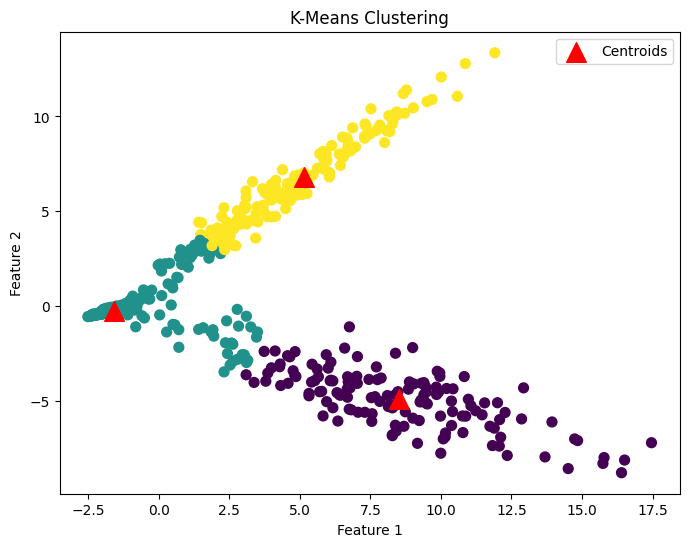

Silhouette Score: 0.63208026
Davies-Bouldin Index: 0.6920175413912565


In [21]:
# Fit KMeans clustering model with a specified number of clusters
n_clusters = 3  # You can adjust this number as needed
kmeans = KMeans(n_clusters=n_clusters)
y_kmeans = kmeans.fit_predict(val_pca_features)

# Check the number of unique labels (clusters)
unique_labels = np.unique(y_kmeans)
num_unique_labels = len(unique_labels)
if num_unique_labels < 2:
    raise ValueError("Number of clusters is insufficient for evaluation.")

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(val_pca_features[:, 0], val_pca_features[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='^', s=200, c='red', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Compute silhouette score and Davies-Bouldin index
silhouette_avg = silhouette_score(val_pca_features, y_kmeans)
db_index = davies_bouldin_score(val_pca_features, y_kmeans)

print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)



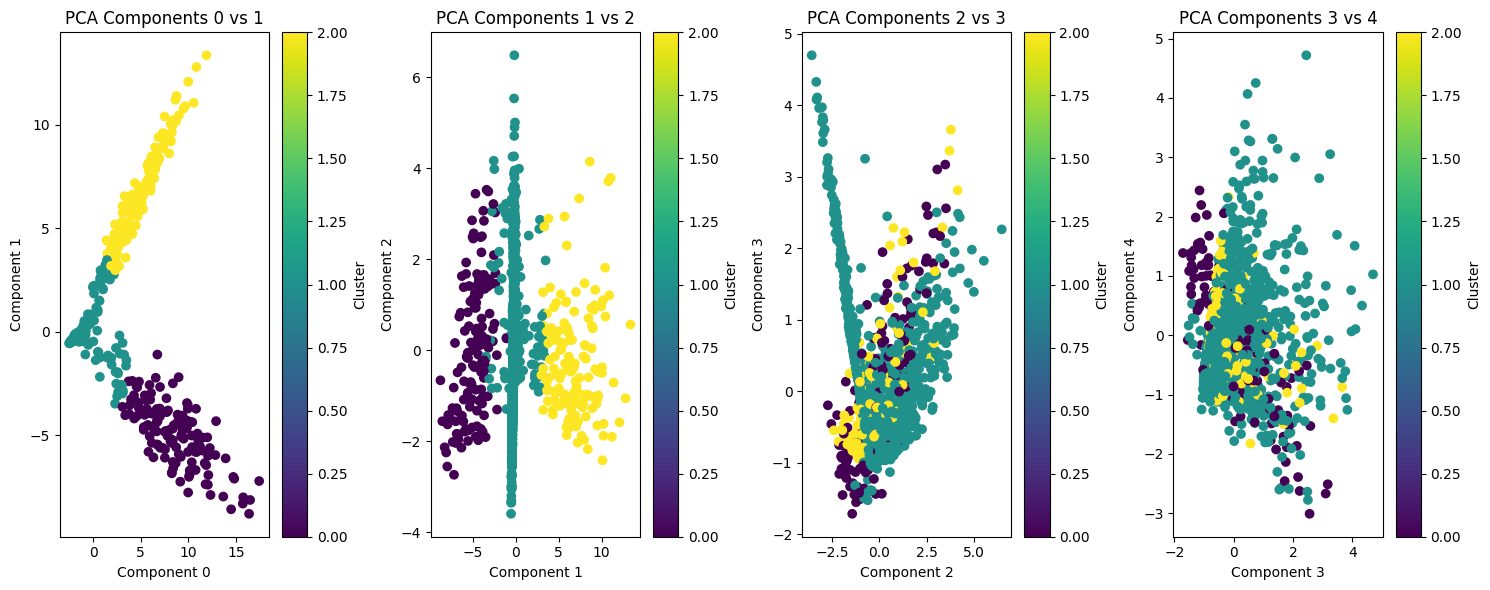

In [24]:
plt.figure(figsize=(15, 6))
for i in range(4):  # Change the range to go up to 4 instead of 5
    plt.subplot(1, 4, i+1)  # Use 1 row and 4 columns for subplots
    plt.scatter(val_pca_features[:, i], val_pca_features[:, i+1], c=y_kmeans, cmap='viridis')
    plt.title(f'PCA Components {i} vs {i+1}')
    plt.xlabel(f'Component {i}')
    plt.ylabel(f'Component {i+1}')
    plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()



In [26]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(val_pca_features, y_kmeans, test_size=0.2, random_state=42)

# Define the multilayer perceptron model
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(dims,)),  # Adjust input shape to match PCA dimensions
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_clusters, activation='softmax')  # Adjust output layer units and activation for clustering
])

# Compile the model
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use sparse categorical crossentropy for clustering

# Train the model
mlp.fit(X_train, y_train, epochs=3, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = mlp.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/3
151/151 [==============================] - 4s 8ms/step - loss: 0.2169 - accuracy: 0.9669 - val_loss: 0.0465 - val_accuracy: 0.9901
Epoch 2/3
151/151 [==============================] - 1s 6ms/step - loss: 0.0345 - accuracy: 0.9868 - val_loss: 0.0359 - val_accuracy: 0.9901
Epoch 3/3
10/10 [==============================] - 0s 8ms/step - loss: 0.0290 - accuracy: 0.9835
Test Accuracy: 0.9834983348846436


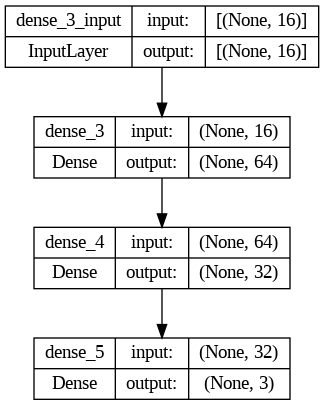

In [27]:
plot_model(mlp, show_shapes=True, show_layer_names=True)

In [30]:
# decision boundary not cmng

# Define the ranges for x and y axes based on the PCA-transformed features
x_min, x_max = val_pca_features[:, 0].min() - 1, val_pca_features[:, 0].max() + 1
y_min, y_max = val_pca_features[:, 1].min() - 1, val_pca_features[:, 1].max() + 1

# Create a meshgrid of points for decision boundary
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Flatten the meshgrid points and concatenate them to create the input
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]

# Make predictions for each point in the meshgrid
Z = mlp.predict(meshgrid_points)
Z = np.argmax(Z, axis=1)  # Convert predictions to cluster labels
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(val_pca_features[:, 0], val_pca_features[:, 1], c=y_kmeans, cmap='viridis', edgecolors='k')
plt.title('Decision Boundary of Neural Network')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()




ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 16), found shape=(None, 2)


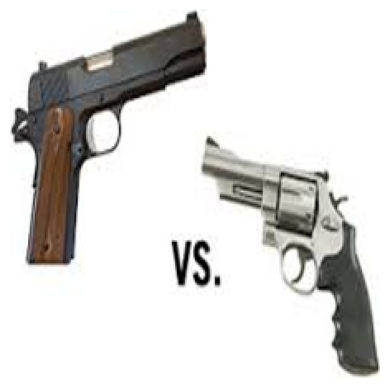

1/1 [==============================] - 2s 2s/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = "/content/dataset/guns/armas (1).jpg"  # Replace with the path to your image file
image = Image.open(image_path)

# Resize the image to 224x224
resized_image = image.resize((224, 224))

# Convert the PIL image to a NumPy array
image_array = np.array(resized_image)

# Preprocess the image array for MobileNet
preprocessed_image_array = tf.keras.applications.mobilenet.preprocess_input(image_array)

num_images = 32
image_array_batch = np.repeat(preprocessed_image_array[np.newaxis, ...], num_images, axis=0)

# Plot the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Turn off axis
plt.show()

# Assuming 'model' is your MobileNet model
embedding = model.predict(image_array_batch, verbose=1)

# Print the embedding
print(embedding)


In [35]:
# Step 1: Compute the mean of each feature
means_ = np.mean(embedding, axis=0)

# Step 2: Compute the standard deviation of each feature
stds_ = np.std(embedding, axis=0)

#embedding[np.isnan(embedding)] = 0
# Step 3: Normalize the features
normalized_embedding = (embedding - means_) / stds_
normalized_embedding[np.isnan(normalized_embedding)] = 0

<ipython-input-35-c862e3a99682>:9: RuntimeWarning: invalid value encountered in divide
  normalized_embedding = (embedding - means_) / stds_
